### Analyses of real-world stochastic data

We use theory developed for the model of two stochastic dealers with memory and analyse the data using techniques practiced earlier in the course. For the large part, we are just reusing previous code.

In [1]:
import numpy as np  # import numpy library as np
import math         # use mathematical functions defined by the C standard
import matplotlib.pyplot as plt # import pyplot library as plt 
import pandas as pd # import pandas library as pd
from datetime import datetime
from numpy import fft

plt.style.use('ggplot') # use "ggplot" style for graphs
pltparams = {'legend.fontsize':16,'axes.labelsize':20,'axes.titlesize':20,
             'xtick.labelsize':12,'ytick.labelsize':12,'figure.figsize':(7.5,7.5),}
plt.rcParams.update(pltparams)
% matplotlib inline

In [2]:
def logreturn(Pt, tau = 1):
    # Logarithmic retruns of price time series:
    logret = np.log(Pt[tau:]) - np.log(Pt[0:-tau])
    return logret
def normalized(data):
    # Normalize data by std to unit variance
    # <(x - <x>)^2> = 1
    return data/np.sqrt(np.var(data))
def pdf_estimate(data, bins = 50):
    hist, edges = np.histogram(data[~np.isnan(data)], bins = bins, density = True)
    centers  = edges[:-1] + np.diff(edges)/2.0 # get bar centers
    nonzero = hist > 0.0
    return hist[nonzero], centers[nonzero]
## Compute autocorrelation
def auto_correlate(x, do_scale = False):
    cor = np.correlate(x, x, mode = "full")/len(x)
    if do_scale:
        cor = cor / np.var(x)
    return cor[len(x)-1:]

In [3]:
params={"L":.01, "c":.01, "dp":.01, "dt":.01**2, 'd': 1.25, 'M':1} # define model parameters
np.random.seed(5)

def model2(params, p0, numt):
    def avgprice(dpn): # compute running average
        M = len(dpn)
        weights = np.array(range(1, M+1)) * 2.0 / (M*(M+1))
        return weights.dot(dpn)
    
    price = np.array([p0[0], p0[1]])
    cdp = params["c"] * params["dp"]
    ddt = params["d"] * params["dt"]
    deltapm = 0.0
    
    mktprice = np.zeros(numt)
    ticktime = np.zeros(numt, dtype = np.int)
    dmktprice = np.zeros(numt) # dP(n) needed for running average
    time, tick = 0, 0
    
    while tick < numt:
        while np.abs(price[0] - price[1]) < params["L"]: # keep trading until we have exceeded the spread
            price = price + np.random.choice([-cdp,cdp], size = 2) # make a radom step
            price = price + deltapm
            time = time + 1
            
        price[:] = np.average(price) # after trade, the new starting posiiton for both is the old mktprice
        mktprice[tick] = price[0] # store the new starting price
        dmktprice[tick] = mktprice[tick] - mktprice[np.max([0, tick -1])] # get delta over one tick
        ticktime[tick] = time
        tick = tick +1
        tick0 = np.max([0, tick - params["M"]]) # compute start tick for the running average
        deltapm = avgprice(dmktprice[tick0:tick]) * ddt # compute update drift term
        
    return ticktime, mktprice

The following code preforms the simulation, we skip it due to its time-requirments and load a precomputed results.

In [ ]:
## Not Run
params={'L':0.01,'c':0.01,'dp':0.01,'dt':0.01**2, 'd':1.00, 'M':10} # define model parameters
price = np.zeros((5,5000))
# run 5 simulations with different d paramaters
for i,d,lbl in zip(range(5),[-2.0, -1.25, 0.0, 1.25, 2.0], ['d-2.0', 'd-1.25', 'd0.0', 'd+1.25', 'd+2.0']):
    np.random.seed(0)
    params['d'] = d
    print(params['d'])
    time,price[i] = model2(params, [100.25, 100.25], 5000)
np.savetxt('model2_M10_5d.txt', np.transpose(price), header="d-2\t d-1\t d0\t d+1\t d+2", comments=' ')

-2.0


We save ourselves some lines of code by storing the data in two separate dataframes:

In [4]:
price  = pd.read_csv('model2_M10_5d.txt', header=0, delim_whitespace=True, index_col=False)
dprice = pd.DataFrame()
for lbl in price.columns:
    dprice[lbl] = normalized(logreturn(price[lbl].values, 1)) #price return G_1
dprice.head()

,d-2,d-1,d0,d+1,d+2
0,0.075109,0.077352,0.079331,0.067509,0.002054
1,-0.238547,-0.233315,-0.218161,-0.167677,-0.004774
2,-0.748482,-0.812069,-0.892503,-0.798769,-0.024852
3,2.275070,2.007255,1.427985,0.637634,0.008543
4,-0.442659,-0.320617,-0.198325,-0.176420,-0.007317


#### Price dynamics of the dealer model:

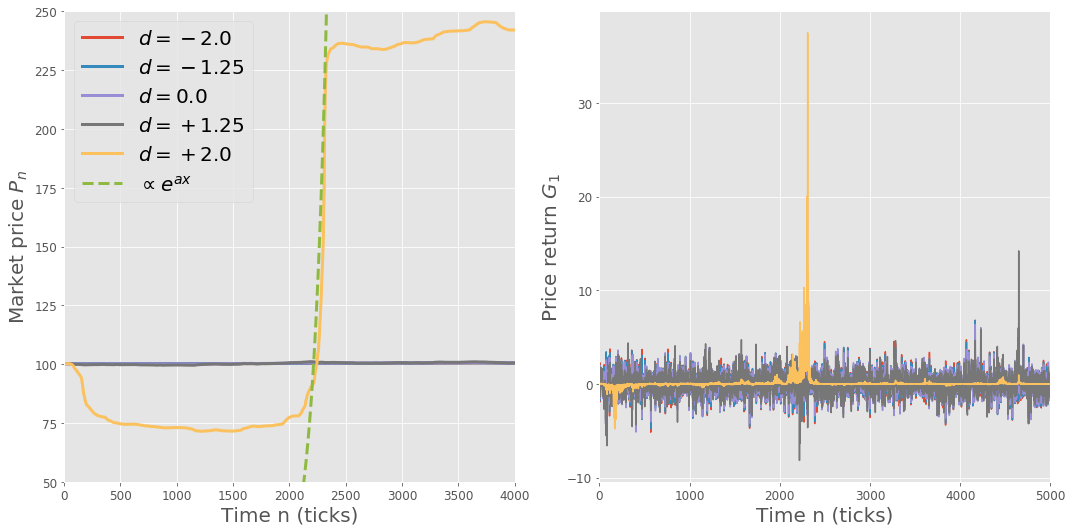

In [5]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
price.plot(ax = ax, lw=3)
dprice.plot(ax = bx, legend=False)

x = np.arange(1000,2550)
ax.plot(x,0.03*np.exp(8e-3*(x-1200)),lw=3,ls='--',label='Exponential')
ax.set_ylim(50,250)
ax.set_xlim(0,4000)
ax.legend([r'$d=-2.0$', r'$d=-1.25$', r'$d=0.0$', r'$d=+1.25$', r'$d=+2.0$', r'$\propto e^{a x}$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')

fig.tight_layout() # get nice spacing between plots
plt.show()

The model with $d=2$ is clearly dominant in the previous plot, let's drop it for now:

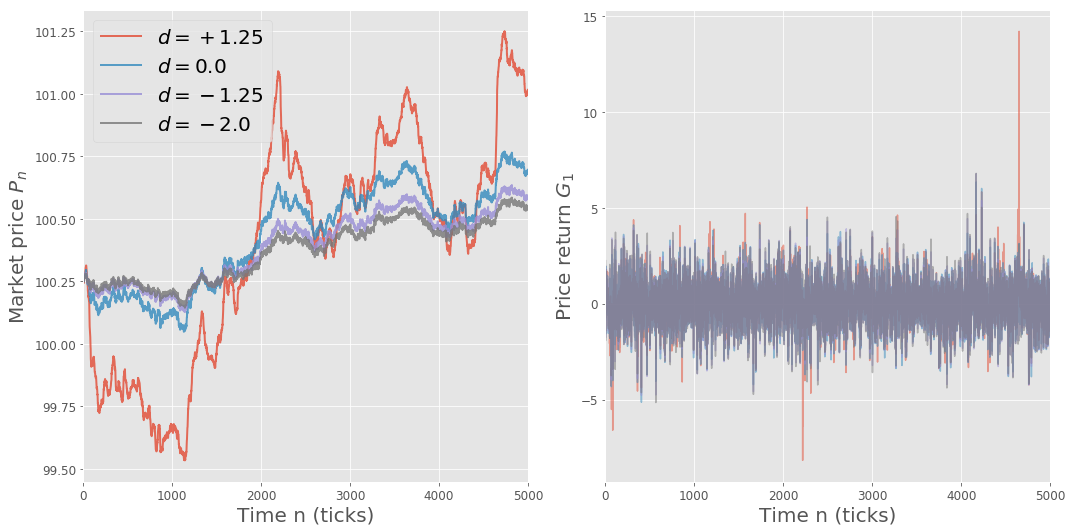

In [6]:
fig,[ax,bx]=plt.subplots(figsize=(15,7.5),ncols=2,subplot_kw={'xlabel':r'Time n (ticks)'})
cols = ['d+1','d0','d-1','d-2']
price[cols].plot(ax=ax, lw=2, alpha=0.8)
dprice[cols].plot(ax=bx, alpha=0.5, legend=False)
ax.legend([r'$d=+1.25$', r'$d=0.0$', r'$d=-1.25$', r'$d=-2.0$'], loc=2, fontsize=20)
ax.set_ylabel(r'Market price $P_n$')
bx.set_ylabel(r'Price return $G_{1}$')
fig.tight_layout() # get nice spacing between plots
plt.show()

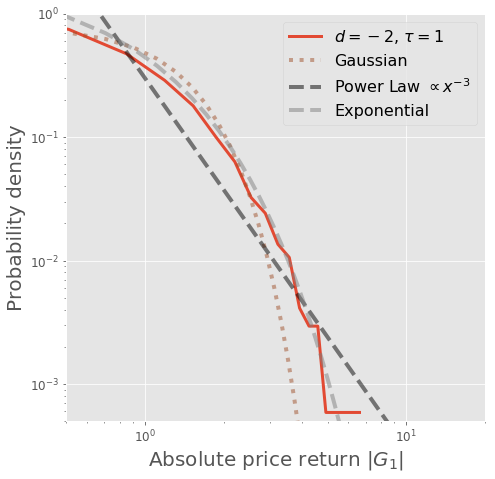

In [24]:
fig,ax, = plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'Absolute price return $|G_1|$', 'ylabel':r'Probability density'})

edges,hist = pdf_estimate(np.abs(dprice["d-2"]),bins=20) # probability density of price change G_1 between ticks
ax.plot(hist, edges,  lw=3, label=r'$d=-2$, $\tau = 1$')

x = np.linspace(0.1, 10)
ax.plot(x,2*np.exp(-x**2/2)/np.sqrt(2*np.pi),lw=4,ls=':',color='sienna',alpha=0.5,label=r'Gaussian')
ax.plot(x,.3*x**(-3), lw=4, ls='--', color='k', alpha=0.5, label=r'Power Law $\propto x^{-3}$')
ax.plot(x, 2*np.exp(-1.5*x), lw=4, color='gray', ls='--', alpha=0.5, label=r'Exponential')

ax.set_xlim(5e-1, 2e1)
ax.set_ylim([5e-4,1])
ax.semilogy()
ax.semilogx()
ax.legend()
plt.show()

As previously, trend-following behaviour leads to more volatile prices.

Let's now look at autocorrelation function:

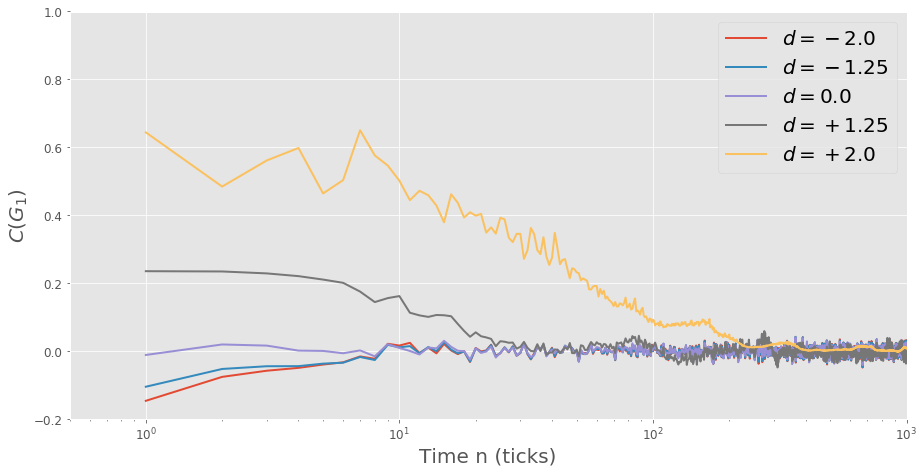

In [26]:
pricecor = pd.DataFrame()
for lbl in dprice.columns:
    ct = auto_correlate(dprice[lbl].values, do_scale = True)
    pricecor[lbl] = ct/ct[0]
fig,ax=plt.subplots(figsize=(15,7.5),subplot_kw={'xlabel':r'Time n (ticks)', 'ylabel':r'$C(G_{1})$'})
pricecor.plot(ax=ax, lw=2)
ax.semilogx()
ax.set_xlim(5e-1,1e3)
ax.set_ylim(-0.2, 1.0)
ax.legend([r'$d=-2.0$', r'$d=-1.25$', r'$d=0.0$', r'$d=+1.25$', r'$d=+2.0$'], loc=0, fontsize=20)
plt.show()

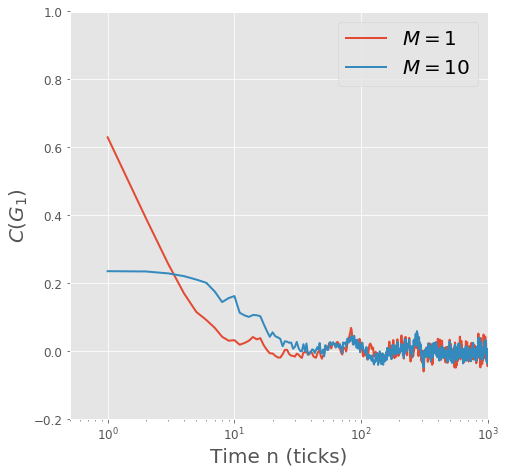

In [28]:
ticktime1, mktprice1 = np.loadtxt("model2.txt", unpack = True)
t_interval1 = normalized((ticktime1[1:] - ticktime1[0:-1])*params["dt"]) #dt between two trades
dprice1 = normalized(logreturn(mktprice1, tau = 1)) # log return over one tick, normalized to unit variance

pricecor2 = pd.DataFrame()
for dp, lbl in zip([dprice1, dprice["d+1"].values], ["Model2", "Model2_M10_5d"]):
    ct = auto_correlate(dp, do_scale = False)
    pricecor2[lbl] = ct/ct[0]
fig,ax=plt.subplots(figsize=(7.5,7.5),subplot_kw={'xlabel':r'Time n (ticks)', 'ylabel':r'$C(G_{1})$'})
pricecor2.plot(ax=ax, lw=2)
ax.semilogx()
ax.set_xlim(5e-1,1e3)
ax.set_ylim(-0.2, 1.0)
ax.legend([r'$M=1$', r'$M=10$'], loc=0, fontsize=20)
plt.show()

This is in-line with our expectationsL trend-following ($d>0$) behavior shows correleation over the length $M$ we use to compute the running average. Anticorrelation si apparent for contrarians ($d<0$) and there is no correlation for memoryless dealers ($d=0$).

One can wonder, how does this look for real world data?

In [8]:
# add logarithmic return data to pandas DataFrame data
def computeReturn(data, pname, dname, tau):
    data[dname]=pd.Series(normalized(logreturn(data[pname].values, tau)),index=data.index[:-tau])
    
# https://www.quantshare.com/sa-426-6-ways-to-download-free-intraday-and-tick-data-for-the-us-stock-market
dateparse = lambda x: pd.datetime.strptime(x, '%Y%m%d %H%M%S')
stocktick = pd.read_csv('US1.GILD_170901_180312_tick.csv', parse_dates={'datetime':['DATE', 'TIME']}, 
                        date_parser=dateparse)
# stocktick = pd.read_csv('US2.AAPL_170301_170301_min.csv', parse_dates={'datetime':['Date', 'Time']}, 
#                         date_parser=dateparse)
stockmin  = pd.read_csv('US1.GILD_170901_180312_min.csv',  parse_dates={'datetime':['DATE', 'TIME']}, 
                        date_parser=dateparse) 
computeReturn(stockmin, 'CLOSE', 'Return d1', 1)
computeReturn(stocktick, 'LAST', 'Return d1', 1)

In [9]:
stockmin.sample(5)

,datetime,TICKER,PER,OPEN,HIGH,LOW,CLOSE,VOL,Return d1
10255,2017-12-05 17:52:00,US1.GILD,1,73.57,73.60,73.360,73.375,3800,0.532997
13823,2017-12-18 20:39:00,US1.GILD,1,75.31,75.31,75.285,75.290,1200,0.000000
13480,2017-12-15 21:17:00,US1.GILD,1,75.60,75.60,75.600,75.600,200,-0.887380
33102,2018-03-05 21:35:00,US1.GILD,1,78.11,78.13,78.070,78.070,1000,-0.143170
32652,2018-03-02 20:35:00,US1.GILD,1,77.91,77.94,77.860,77.860,1200,0.287057


In [10]:
stocktick.sample(5)

,datetime,TICKER,PER,LAST,VOL,Return d1
156260,2018-01-05 12:37:31,US1.GILD,0,73.74,700,0.494630
260349,2018-02-09 15:59:42,US1.GILD,0,79.38,100,-0.459546
17802,2017-10-27 15:50:00,US1.GILD,0,76.65,100,6.656289
242243,2018-02-07 12:39:58,US1.GILD,0,83.03,100,0.000000
142150,2017-12-27 12:07:14,US1.GILD,0,73.07,100,0.000000


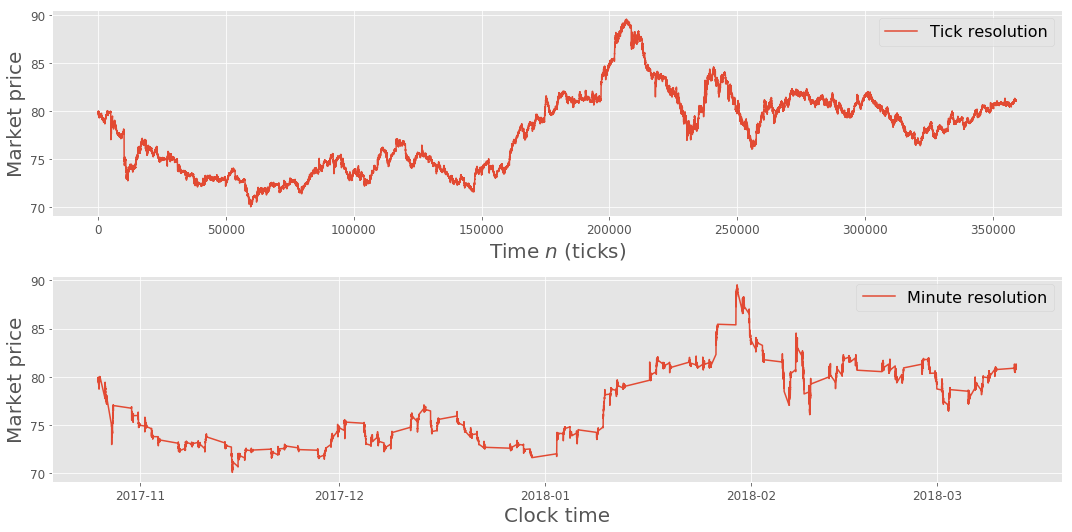

In [11]:
fig, [ax,bx] = plt.subplots(figsize=(15,7.5), nrows=2, subplot_kw={'ylabel':r'Market price'})
ax.plot(stocktick.index, stocktick['LAST'], label = "Tick resolution")
ax.legend()
bx.plot(stockmin['datetime'], stockmin['CLOSE'], label = "Minute resolution")
bx.legend()
#ax.set_xlim(0,15398)
ax.set_xlabel('Time $n$ (ticks)')
bx.set_xlabel('Clock time')
plt.tight_layout()
plt.show()

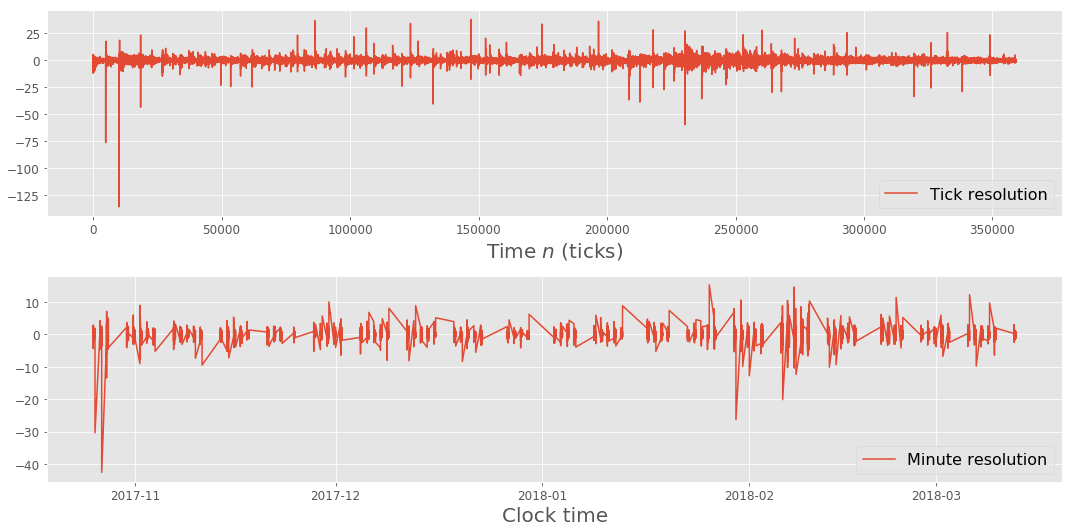

In [12]:
fig, [ax,bx] = plt.subplots(figsize=(15,7.5), nrows=2, subplot_kw={'xlabel':r'Price return $G_{1}$'})
ax.plot(stocktick.index, stocktick['Return d1'], label = "Tick resolution")
ax.legend()
bx.plot(stockmin['datetime'], stockmin['Return d1'], label = "Minute resolution")
bx.legend()
#ax.set_xlim(0,15398)
ax.set_xlabel('Time $n$ (ticks)')
bx.set_xlabel('Clock time')
plt.tight_layout()
plt.show()

From what we can see, it appears that there is some automatic trading taking place. There are patterns appaerent in the data, mainly at the minute resolution. It is not clear how these have been produced, but we notice that volumes of traded stocks for both time and minute resolution tend to be rounded to hundreds, not really representative of real stock trade-volumes.

In [13]:
## Compute autocorrelation
def computeCt(data, name, trim = 20):
    ct = auto_correlate(data[name].values[:-trim], do_scale = True) # ignore NaN last point
    data['Ct'] = pd.Series(ct, index=data.index[:-trim])
computeCt(stocktick, "Return d1")
computeCt(stockmin, "Return d1")

In [19]:
stockmin.to_hdf("US1.GILD_170901_180312_min.h5", key = "stocktick", format = "t", 
                #complib = "zlib", complevel = "5", ,
               #data_columns = [sc for sc in stockmin.columns if sc != "TICKER"])
               )
stocktick.to_hdf("US1.GILD_170901_180312_tick.h5", key = "stockmin", format = "t", 
                #complib = "zlib", complevel = "5", 
                #data_columns = [sc for sc in stocktick.columns if sc != "TICKER"])
                )

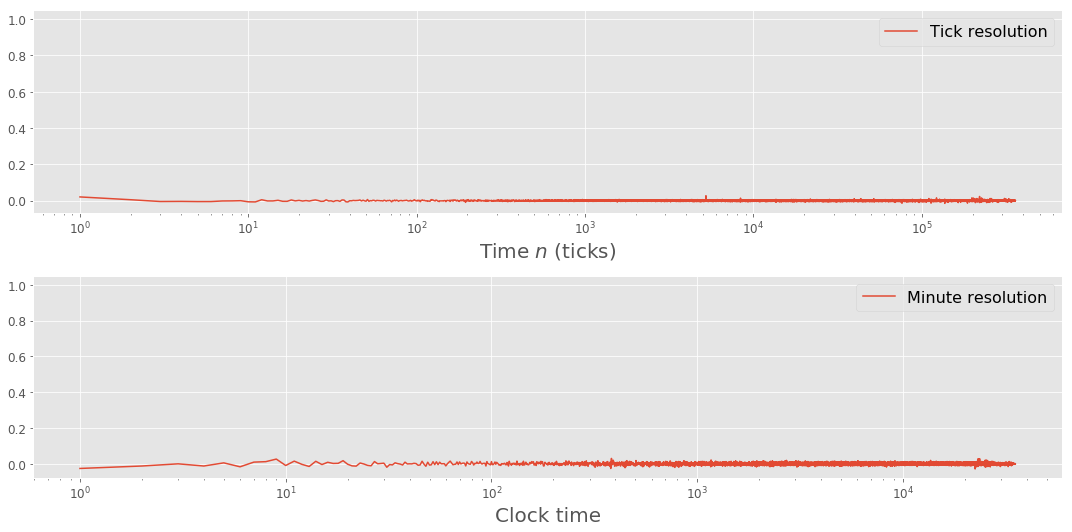

In [21]:
fig, [ax,bx] = plt.subplots(figsize=(15,7.5), nrows=2, subplot_kw={'xlabel':r'Correlation'})
ax.plot(stocktick.index, stocktick['Ct'], label = "Tick resolution")
ax.legend()
bx.plot(stockmin['Ct'], label = "Minute resolution")
bx.legend()
#ax.set_xlim(0,15398)
ax.set_xlabel('Time $n$ (ticks)')
bx.set_xlabel('Clock time')
plt.tight_layout()
ax.semilogx()
bx.semilogx()
#ax.set_ylim(-0.05, 0.05)
#bx.set_ylim(-0.2, 0.2)
#bx.set_xlim(1e-2,6e2)
plt.tight_layout()
plt.show()

We have found no correlation what so ever.